# Advanced Ultramarathon Lottery Analysis

Multiple forecasting models and demographic predictions for 2026.

In [9]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
print('Libraries loaded!')

Libraries loaded!


In [14]:
# Load data
years = [2020, 2021, 2022, 2023, 2024, 2025]
datasets = {}
for year in years:
    filename = f'{year}HLdata.csv'
    for encoding in ['utf-8', 'cp1252', 'latin1']:
        try:
            df = pd.read_csv(filename, encoding=encoding)
            datasets[year] = df
            print(f'✓ {year}: {len(df):,} applications')
            break
        except:
            continue
print(f'Loaded {len(datasets)} datasets')

✓ 2020: 331 applications
✓ 2021: 145 applications
✓ 2022: 415 applications
✓ 2023: 538 applications
✓ 2024: 773 applications
✓ 2025: 958 applications
Loaded 6 datasets


In [15]:
# Clean and standardize data
cleaned_datasets = {}
for year, df in datasets.items():
    df_clean = df.copy()
    
    # Clean age data (only if Age column exists - 2021 doesn't have it)
    if 'Age' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['Age'])
        df_clean = df_clean[(df_clean['Age'] > 0) & (df_clean['Age'] < 100)]
    
    # Standardize gender from Lottery Pool
    df_clean['Gender'] = df_clean['Lottery Pool'].str.strip()
    
    # Create age groups (only if Age column exists)
    if 'Age' in df_clean.columns:
        df_clean['Age_Group'] = pd.cut(df_clean['Age'], 
                                       bins=[0, 30, 40, 50, 60, 100], 
                                       labels=['Under 30', '30-39', '40-49', '50-59', '60+'])
    
    cleaned_datasets[year] = df_clean
    print(f'{year}: {len(df_clean):,} clean records')
print('Data cleaned!')

2020: 331 clean records
2021: 145 clean records
2022: 415 clean records
2023: 538 clean records
2024: 773 clean records
2025: 958 clean records
Data cleaned!


In [16]:
# Enhanced longitudinal dataset creation with trailwork, volunteer, and finish tracking
# Building on your existing datasets and cleaned_datasets

import pandas as pd
import numpy as np

print(f"Using existing datasets for years: {list(datasets.keys())}")
print(f"Using existing cleaned_datasets for years: {list(cleaned_datasets.keys())}")

# Check if 2025 is missing from cleaned_datasets but present in datasets
if 2025 in datasets and 2025 not in cleaned_datasets:
    print("WARNING: 2025 is in datasets but not in cleaned_datasets!")
    print("2025 might have been dropped during cleaning due to missing Age column")
    print(f"2025 columns: {list(datasets[2025].columns)}")
    
    # Add 2025 to cleaned_datasets manually if needed
    df_2025 = datasets[2025].copy()
    
    # Apply same cleaning logic but handle missing Age column
    if 'Age' in df_2025.columns:
        df_2025 = df_2025.dropna(subset=['Age'])
        df_2025 = df_2025[(df_2025['Age'] > 0) & (df_2025['Age'] < 100)]
        df_2025['Age_Group'] = pd.cut(df_2025['Age'], 
                                     bins=[0, 30, 40, 50, 60, 100], 
                                     labels=['Under 30', '30-39', '40-49', '50-59', '60+'])
    else:
        print("2025 has no Age column - keeping all records")
    
    # Standardize gender 
    if 'Lottery Pool' in df_2025.columns:
        df_2025['Gender'] = df_2025['Lottery Pool'].str.strip()
    
    cleaned_datasets[2025] = df_2025
    print(f"Added 2025 to cleaned_datasets: {len(df_2025):,} records")

# Function to standardize column names across years
def get_standardized_value(row, possible_cols, default_value=0):
    """Extract value from row using various possible column names"""
    for col in possible_cols:
        if col in row.index and pd.notna(row[col]):
            return row[col]
    return default_value

# Create master list of all unique individuals with enhanced tracking
all_individuals = {}

for year, df in cleaned_datasets.items():
    # Clean names for matching
    df_temp = df.copy()
    df_temp['first_name_clean'] = df_temp['First_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    df_temp['last_name_clean'] = df_temp['Last_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    
    # Create person identifier
    df_temp['person_id'] = df_temp['first_name_clean'] + '_' + df_temp['last_name_clean']
    
    for _, row in df_temp.iterrows():
        person_id = row['person_id']
        
        if person_id not in all_individuals:
            all_individuals[person_id] = {
                'first_name': row['First_Name'],
                'last_name': row['Last_Name'],
                'city': row.get('City', 'Unknown'),
                'state': row.get('State', 'Unknown'),
                'gender': row.get('Gender', 'Unknown'),
                'ages': {},
                'years_applied': [],
                # Enhanced tracking dictionaries
                'trailwork_points': {},
                'volunteer_points': {},
                'previous_finishes': {},
                'previous_applications': {}
            }
        
        # Update with most complete/recent information
        if pd.notna(row.get('City')) and row.get('City', '') != '':
            all_individuals[person_id]['city'] = row['City']
        if pd.notna(row.get('State')) and row.get('State', '') != '':
            all_individuals[person_id]['state'] = row['State']
        if pd.notna(row.get('Gender')) and row.get('Gender', '') != '':
            all_individuals[person_id]['gender'] = row['Gender']
        if 'Age' in row and pd.notna(row['Age']):
            all_individuals[person_id]['ages'][year] = row['Age']
            
        all_individuals[person_id]['years_applied'].append(year)
        
        # Extract trailwork points using various column name conventions
        trailwork = get_standardized_value(row, [
            'Extra_Trailwork_Points', 'Extra_Trailwork', 'Trailwork'
        ], 0)
        all_individuals[person_id]['trailwork_points'][year] = trailwork
        
        # Extract volunteer points/shifts using various column name conventions  
        volunteer = get_standardized_value(row, [
            'Volunteer_Points', 'Volunteer_Shifts'
        ], 0)
        all_individuals[person_id]['volunteer_points'][year] = volunteer
        
        # Extract previous finishes
        prev_finishes = get_standardized_value(row, [
            'Previous_Finishes'
        ], 0)
        all_individuals[person_id]['previous_finishes'][year] = prev_finishes
        
        # Extract previous applications
        prev_apps = get_standardized_value(row, [
            'Previous_Applications'
        ], 0)
        all_individuals[person_id]['previous_applications'][year] = prev_apps

print(f"\nUnique individuals identified: {len(all_individuals):,}")

# Calculate enhanced metrics for each person
years_available = sorted(list(datasets.keys()))

for person_id, person_data in all_individuals.items():
    ages = person_data['ages']
    
    # Age estimation (existing logic)
    if ages:
        if 2025 in ages:
            person_data['age_2025'] = ages[2025]
        else:
            most_recent_year = max(ages.keys())
            most_recent_age = ages[most_recent_year]
            person_data['age_2025'] = most_recent_age + (2025 - most_recent_year)
    else:
        person_data['age_2025'] = np.nan
    
    # Calculate enhanced tracking metrics
    trailwork_years = person_data['trailwork_points']
    volunteer_years = person_data['volunteer_points']
    finish_years = person_data['previous_finishes']
    app_years = person_data['previous_applications']
    
    # Total and cumulative metrics
    person_data['total_trailwork'] = sum(trailwork_years.values())
    person_data['total_volunteer'] = sum(volunteer_years.values())
    person_data['max_reported_finishes'] = max(finish_years.values()) if finish_years else 0
    person_data['max_reported_applications'] = max(app_years.values()) if app_years else 0
    
    # Participation patterns
    person_data['years_participated'] = len(person_data['years_applied'])
    person_data['first_year'] = min(person_data['years_applied']) if person_data['years_applied'] else np.nan
    person_data['last_year'] = max(person_data['years_applied']) if person_data['years_applied'] else np.nan
    
    # Activity patterns
    person_data['years_with_trailwork'] = len([y for y, v in trailwork_years.items() if v > 0])
    person_data['years_with_volunteer'] = len([y for y, v in volunteer_years.items() if v > 0])
    
    # Average effort per year
    if person_data['years_participated'] > 0:
        person_data['avg_trailwork_per_year'] = person_data['total_trailwork'] / person_data['years_participated']
        person_data['avg_volunteer_per_year'] = person_data['total_volunteer'] / person_data['years_participated']
    else:
        person_data['avg_trailwork_per_year'] = 0
        person_data['avg_volunteer_per_year'] = 0

# Create enhanced longitudinal dataset
longitudinal_data = []

for person_id, person_data in all_individuals.items():
    row = {
        'person_id': person_id,
        'first_name': person_data['first_name'],
        'last_name': person_data['last_name'],
        'city': person_data['city'],
        'state': person_data['state'],
        'gender': person_data['gender'],
        'age_2025': person_data['age_2025'],
        
        # Participation summary
        'years_participated': person_data['years_participated'],
        'first_year': person_data['first_year'],
        'last_year': person_data['last_year'],
        
        # Enhanced tracking totals
        'total_trailwork': person_data['total_trailwork'],
        'total_volunteer': person_data['total_volunteer'],
        'max_reported_finishes': person_data['max_reported_finishes'],
        'max_reported_applications': person_data['max_reported_applications'],
        
        # Activity patterns
        'years_with_trailwork': person_data['years_with_trailwork'],
        'years_with_volunteer': person_data['years_with_volunteer'],
        'avg_trailwork_per_year': person_data['avg_trailwork_per_year'],
        'avg_volunteer_per_year': person_data['avg_volunteer_per_year'],
        
        # Binary indicators
        'ever_trailwork': person_data['total_trailwork'] > 0,
        'ever_volunteer': person_data['total_volunteer'] > 0,
        'has_finish_history': person_data['max_reported_finishes'] > 0
    }
    
    # Add yearly application indicators (fill blanks with zeros)
    for year in [2020, 2021, 2022, 2023, 2024, 2025]:
        if year in years_available:
            row[f'applied_{year}'] = int(year in person_data['years_applied'])
        else:
            row[f'applied_{year}'] = 0  # Fill with zero instead of NaN
    
    # Add yearly trailwork, volunteer, and finish data (fill blanks with zeros)
    for year in years_available:
        row[f'trailwork_{year}'] = person_data['trailwork_points'].get(year, 0)
        row[f'volunteer_{year}'] = person_data['volunteer_points'].get(year, 0)
        row[f'prev_finishes_{year}'] = person_data['previous_finishes'].get(year, 0)
        row[f'prev_apps_{year}'] = person_data['previous_applications'].get(year, 0)
    
    longitudinal_data.append(row)

# Convert to DataFrame
longitudinal_df = pd.DataFrame(longitudinal_data)

# Clean up the data
longitudinal_df['city'] = longitudinal_df['city'].replace(['Unknown', ''], np.nan)
longitudinal_df['state'] = longitudinal_df['state'].replace(['Unknown', ''], np.nan)
longitudinal_df['gender'] = longitudinal_df['gender'].replace(['Unknown', ''], np.nan)

print(f"\nEnhanced longitudinal dataset created: {len(longitudinal_df)} individuals")
print(f"Columns: {len(longitudinal_df.columns)} total columns")

# Enhanced summary statistics
print(f"\n=== ENHANCED SUMMARY STATISTICS ===")
print(f"Mean age in 2025: {longitudinal_df['age_2025'].mean():.1f}")
print(f"Age range: {longitudinal_df['age_2025'].min():.0f} to {longitudinal_df['age_2025'].max():.0f}")

print(f"\n=== PARTICIPATION PATTERNS ===")
participation_counts = longitudinal_df['years_participated'].value_counts().sort_index()
for years, count in participation_counts.items():
    pct = 100 * count / len(longitudinal_df)
    print(f"{years} year(s): {count:,} people ({pct:.1f}%)")

print(f"\n=== TRAILWORK & VOLUNTEER ENGAGEMENT ===")
print(f"People with any trailwork: {longitudinal_df['ever_trailwork'].sum():,} ({100*longitudinal_df['ever_trailwork'].mean():.1f}%)")
print(f"People with any volunteer work: {longitudinal_df['ever_volunteer'].sum():,} ({100*longitudinal_df['ever_volunteer'].mean():.1f}%)")
print(f"Mean total trailwork points: {longitudinal_df['total_trailwork'].mean():.2f}")
print(f"Mean total volunteer points: {longitudinal_df['total_volunteer'].mean():.2f}")
print(f"Max trailwork by individual: {longitudinal_df['total_trailwork'].max():.1f}")
print(f"Max volunteer by individual: {longitudinal_df['total_volunteer'].max():.1f}")

print(f"\n=== RACE HISTORY ===")
print(f"People with finish history: {longitudinal_df['has_finish_history'].sum():,} ({100*longitudinal_df['has_finish_history'].mean():.1f}%)")
print(f"Mean max finishes reported: {longitudinal_df['max_reported_finishes'].mean():.2f}")
print(f"Max finishes by individual: {longitudinal_df['max_reported_finishes'].max()}")

print(f"\nGender distribution:")
print(longitudinal_df['gender'].value_counts().to_string())

print(f"\nTop 10 states:")
print(longitudinal_df['state'].value_counts().head(10).to_string())

# Show application patterns
print(f"\n=== APPLICATION PATTERNS BY YEAR ===")
for year in [2020, 2021, 2022, 2023, 2024, 2025]:
    col = f'applied_{year}'
    if col in longitudinal_df.columns:
        applied = longitudinal_df[col].sum()
        total_possible = longitudinal_df[col].notna().sum()
        if total_possible > 0:
            print(f"{year}: {applied:,} applicants")

# Data validation checks
print(f"\n=== DATA VALIDATION ===")
# Check for inconsistent application counts (should generally be non-decreasing)
validation_issues = 0
for year_cols in [['prev_apps_2021', 'prev_apps_2022'], ['prev_apps_2022', 'prev_apps_2023'], 
                  ['prev_apps_2023', 'prev_apps_2024'], ['prev_apps_2024', 'prev_apps_2025']]:
    if all(col in longitudinal_df.columns for col in year_cols):
        inconsistent = longitudinal_df[
            (longitudinal_df[year_cols[0]].notna()) & 
            (longitudinal_df[year_cols[1]].notna()) & 
            (longitudinal_df[year_cols[1]] < longitudinal_df[year_cols[0]])
        ]
        if len(inconsistent) > 0:
            validation_issues += len(inconsistent)
            print(f"Found {len(inconsistent)} people with decreasing app counts between {year_cols[0]} and {year_cols[1]}")

if validation_issues == 0:
    print("No obvious data validation issues found")

# Save enhanced dataset
longitudinal_df.to_csv('longitudinal_data.csv', index=False)
print(f"\nEnhanced dataset saved as 'longitudinal_data.csv'")

# Show sample of enhanced data
print(f"\n=== SAMPLE OF ENHANCED DATASET ===")
sample_cols = ['person_id', 'years_participated', 'total_trailwork', 'total_volunteer', 
               'max_reported_finishes', 'ever_trailwork', 'ever_volunteer']
available_sample_cols = [col for col in sample_cols if col in longitudinal_df.columns]
print(longitudinal_df[available_sample_cols].head().to_string())

# Show year-by-year data for a few active participants
print(f"\n=== YEAR-BY-YEAR SAMPLE (Multi-year participants) ===")
multi_year_sample = longitudinal_df[longitudinal_df['years_participated'] >= 3].head(3)
yearly_cols = [col for col in longitudinal_df.columns if any(col.startswith(prefix) for prefix in ['applied_', 'trailwork_', 'volunteer_', 'prev_finishes_'])]
if len(multi_year_sample) > 0 and yearly_cols:
    print(multi_year_sample[['person_id'] + yearly_cols[:8]].to_string())  # Show first 8 yearly columns

Using existing datasets for years: [2020, 2021, 2022, 2023, 2024, 2025]
Using existing cleaned_datasets for years: [2020, 2021, 2022, 2023, 2024, 2025]

Unique individuals identified: 2,203

Enhanced longitudinal dataset created: 2203 individuals
Columns: 51 total columns

=== ENHANCED SUMMARY STATISTICS ===
Mean age in 2025: 40.8
Age range: 14 to 75

=== PARTICIPATION PATTERNS ===
1 year(s): 1,522 people (69.1%)
2 year(s): 469 people (21.3%)
3 year(s): 160 people (7.3%)
4 year(s): 43 people (2.0%)
5 year(s): 6 people (0.3%)
6 year(s): 3 people (0.1%)

=== TRAILWORK & VOLUNTEER ENGAGEMENT ===
People with any trailwork: 204 (9.3%)
People with any volunteer work: 213 (9.7%)
Mean total trailwork points: 0.23
Mean total volunteer points: 0.63
Max trailwork by individual: 30.0
Max volunteer by individual: 45.5

=== RACE HISTORY ===
People with finish history: 180 (8.2%)
Mean max finishes reported: 0.10
Max finishes by individual: 4

Gender distribution:
gender
M    1576
F     627

Top 10 st

In [17]:
# Calculate comprehensive statistics
yearly_stats = {}
for year, df in cleaned_datasets.items():
    gender_counts = df['Gender'].value_counts()
    total = len(df)
    
    # Initialize stats dictionary
    stats = {
        'total_applications': total,
        'female_percent': (gender_counts.get('F', 0) / total) * 100,
    }
    
    # Age-related stats (only if Age column exists)
    if 'Age' in df.columns:
        age_group_counts = df['Age_Group'].value_counts()
        stats.update({
            'avg_age': df['Age'].mean(),
            'under_30_pct': (age_group_counts.get('Under 30', 0) / total) * 100,
            'age_30_39_pct': (age_group_counts.get('30-39', 0) / total) * 100,
            'age_40_49_pct': (age_group_counts.get('40-49', 0) / total) * 100,
            'age_50_plus_pct': ((age_group_counts.get('50-59', 0) + age_group_counts.get('60+', 0)) / total) * 100
        })
    else:
        # Set None for missing age data
        stats.update({
            'avg_age': None,
            'under_30_pct': None,
            'age_30_39_pct': None,
            'age_40_49_pct': None,
            'age_50_plus_pct': None
        })
    
    # Previous applications (2020 was first lottery, so no previous apps possible)
    if year == 2020:
        stats['avg_previous_apps'] = 0.0  # First lottery ever
    elif 'Previous_Applications' in df.columns:
        stats['avg_previous_apps'] = df['Previous_Applications'].fillna(0).mean()
    else:
        stats['avg_previous_apps'] = None
    
    yearly_stats[year] = stats
    
    # Print summary with conditional formatting
    if stats['avg_age'] is not None:
        print(f'{year}: {total:,} apps, {stats["avg_age"]:.1f} avg age, {stats["female_percent"]:.1f}% F')
    else:
        print(f'{year}: {total:,} apps, No age data, {stats["female_percent"]:.1f}% F')
        
print('Statistics calculated!')

2020: 331 apps, 40.9 avg age, 27.8% F
2021: 145 apps, No age data, 20.0% F
2022: 415 apps, 40.1 avg age, 26.5% F
2023: 538 apps, 39.0 avg age, 28.1% F
2024: 773 apps, 39.7 avg age, 26.0% F
2025: 958 apps, 39.1 avg age, 25.4% F
Statistics calculated!


In [18]:
# Multiple forecasting models
years_list = sorted(yearly_stats.keys())
years_array = np.array(years_list).reshape(-1, 1)
applications_array = np.array([yearly_stats[y]['total_applications'] for y in years_list])

print('=== MULTIPLE FORECASTING MODELS ===')
print(f'Historical data: {dict(zip(years_list, applications_array))}')

models_results = {}

# 1. Linear Trend
linear_model = LinearRegression()
linear_model.fit(years_array, applications_array)
linear_pred = linear_model.predict([[2026]])[0]
linear_r2 = r2_score(applications_array, linear_model.predict(years_array))
models_results['Linear'] = {'prediction': linear_pred, 'r2': linear_r2}
print(f'Linear: {linear_pred:,.0f} (R² = {linear_r2:.3f})')

# 2. Exponential Growth
log_apps = np.log(applications_array)
exp_model = LinearRegression()
exp_model.fit(years_array, log_apps)
exp_pred = np.exp(exp_model.predict([[2026]])[0])
exp_r2 = r2_score(log_apps, exp_model.predict(years_array))
models_results['Exponential'] = {'prediction': exp_pred, 'r2': exp_r2}
print(f'Exponential: {exp_pred:,.0f} (R² = {exp_r2:.3f})')

# 3. Polynomial (Quadratic)
poly_coeffs = np.polyfit(years_list, applications_array, 2)
poly_pred = np.polyval(poly_coeffs, 2026)
poly_fitted = np.polyval(poly_coeffs, years_list)
poly_r2 = r2_score(applications_array, poly_fitted)
models_results['Polynomial'] = {'prediction': poly_pred, 'r2': poly_r2}
print(f'Polynomial: {poly_pred:,.0f} (R² = {poly_r2:.3f})')

# 4. Ensemble (weighted by R²)
total_weight = linear_r2 + exp_r2 + poly_r2
ensemble_pred = (linear_pred * linear_r2 + exp_pred * exp_r2 + poly_pred * poly_r2) / total_weight
models_results['Ensemble'] = {'prediction': ensemble_pred, 'r2': None}

all_preds = [linear_pred, exp_pred, poly_pred]
print(f'\nEnsemble (R²-weighted): {ensemble_pred:,.0f}')
print(f'Range: {min(all_preds):,.0f} - {max(all_preds):,.0f}')

=== MULTIPLE FORECASTING MODELS ===
Historical data: {2020: np.int64(331), 2021: np.int64(145), 2022: np.int64(415), 2023: np.int64(538), 2024: np.int64(773), 2025: np.int64(958)}
Linear: 1,041 (R² = 0.852)
Exponential: 1,288 (R² = 0.704)
Polynomial: 1,327 (R² = 0.931)

Ensemble (R²-weighted): 1,218
Range: 1,041 - 1,327


In [20]:
# Create more robust individual tracking with fuzzy matching
print('=== CREATING ROBUST INDIVIDUAL TRACKING ===')

# Step 1: Clean and unify individual records across all years
all_individuals_robust = pd.DataFrame()

for year, df in cleaned_datasets.items():
    df_temp = df.copy()
    
    # Clean names aggressively
    df_temp['First_Name_Clean'] = df_temp['First_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    df_temp['Last_Name_Clean'] = df_temp['Last_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    df_temp['Person_ID_Name'] = df_temp['First_Name_Clean'] + '_' + df_temp['Last_Name_Clean']
    
    # Clean state info
    if 'State' in df_temp.columns:
        df_temp['State_Clean'] = df_temp['State'].str.strip().str.upper()
    else:
        df_temp['State_Clean'] = 'UNKNOWN'
    
    df_temp['Year'] = year

    # Normalize gender column if Lottery Pool not present
    if 'Lottery Pool' not in df_temp.columns and 'Gender' in df_temp.columns:
        df_temp['Lottery Pool'] = df_temp['Gender']
    
    # Define usable columns
    base_cols = ['Person_ID_Name', 'Year', 'First_Name_Clean', 'Last_Name_Clean', 'State_Clean',
                 'Age', 'Lottery Pool', 'Previous_Applications', 'Previous_Finishes',
                 'Volunteer_Shifts', 'Extra_Trailwork']
    
    available_cols = [col for col in base_cols if col in df_temp.columns]
    df_year = df_temp[available_cols].copy()
    
    all_individuals_robust = pd.concat([all_individuals_robust, df_year], ignore_index=True)

print(f'Total individual-year observations: {len(all_individuals_robust):,}')

# Step 2: Group by Person_ID_Name and resolve ambiguous identities
person_history_robust = {}
name_groups = all_individuals_robust.groupby('Person_ID_Name')

for name_id, group_data in name_groups:
    unique_states = group_data['State_Clean'].dropna().unique()
    
    # Heuristic for disambiguating people with the same name
    if len(unique_states) <= 2 and 'UNKNOWN' not in unique_states:
        state_mode = group_data['State_Clean'].mode()
        if not state_mode.empty:
            best_state = state_mode.iloc[0]
        else:
            best_state = unique_states[0] if len(unique_states) > 0 else 'UNKNOWN'
        person_id = f"{name_id}_{best_state}"
    elif 'UNKNOWN' in unique_states and len(unique_states) == 2:
        best_state = [s for s in unique_states if s != 'UNKNOWN'][0]
        person_id = f"{name_id}_{best_state}"
    else:
        person_id = f"{name_id}_MULTI"
    
    person_data = group_data.sort_values('Year')
    if len(person_data) == 0:
        continue
    
    latest_record = person_data.iloc[-1]
    
    latest_age = latest_record.get('Age', 35)
    latest_gender = latest_record.get('Lottery Pool', 'M')
    latest_state = latest_record.get('State_Clean', 'UNKNOWN')
    
    person_history_robust[person_id] = {
        'first_name': latest_record['First_Name_Clean'],
        'last_name': latest_record['Last_Name_Clean'],
        'state': latest_state,
        'gender': latest_gender,
        'latest_age': latest_age,
        'years_applied': list(person_data['Year']),
        'num_applications': len(person_data),
        'first_year': min(person_data['Year']),
        'last_year': max(person_data['Year']),
        'application_pattern': [],
        'finish_pattern': [],
        'volunteer_pattern': [],
        'trailwork_pattern': []
    }
    
    for _, row in person_data.iterrows():
        person_history_robust[person_id]['application_pattern'].append(row.get('Previous_Applications', 0))
        person_history_robust[person_id]['finish_pattern'].append(row.get('Previous_Finishes', 0))
        person_history_robust[person_id]['volunteer_pattern'].append(row.get('Volunteer_Shifts', 0))
        person_history_robust[person_id]['trailwork_pattern'].append(row.get('Extra_Trailwork', 0))

print(f'Unique individuals tracked (robust): {len(person_history_robust):,}')

# Step 3: Analyze return behavior with robust IDs
print('\n=== ROBUST RETURN RATE ANALYSIS ===')

years_sorted = sorted(all_individuals_robust['Year'].unique())
for year in years_sorted[1:]:
    prev_year = year - 1
    prev_names = set(all_individuals_robust[all_individuals_robust['Year'] == prev_year]['Person_ID_Name'])
    curr_names = set(all_individuals_robust[all_individuals_robust['Year'] == year]['Person_ID_Name'])
    
    if len(prev_names) == 0:
        continue
    
    returning = len(prev_names.intersection(curr_names))
    return_rate = returning / len(prev_names) * 100
    
    print(f'Return rate {prev_year}→{year}: {return_rate:.1f}%')
    print(f'  {prev_year} applicants: {len(prev_names):,}')
    print(f'  {year} applicants: {len(curr_names):,}')
    print(f'  Returning: {returning:,}')
    
    if returning > 0:
        print(f'  Example returners: {list(prev_names.intersection(curr_names))[:5]}')

# Step 4: Show sample of multi-year applicants
print(f'\n=== MULTI-YEAR APPLICANT EXAMPLES ===')
count = 0
for pid, info in person_history_robust.items():
    if len(info['years_applied']) > 1 and count < 5:
        print(f"{info['first_name']} {info['last_name']} ({info['state']}):")
        print(f"  Applied: {info['years_applied']}")
        print(f"  Previous Apps progression: {info['application_pattern']}")
        print()
        count += 1

# Final step: make globally available
person_history = person_history_robust



=== CREATING ROBUST INDIVIDUAL TRACKING ===
Total individual-year observations: 3,160
Unique individuals tracked (robust): 2,203

=== ROBUST RETURN RATE ANALYSIS ===
Return rate 2020→2021: 13.0%
  2020 applicants: 331
  2021 applicants: 145
  Returning: 43
  Example returners: ['James_Flanary', 'Eric_Pence', 'Suzanna_Bon', 'Drew_Hoehn', 'Skye_Thompson']
Return rate 2021→2022: 26.9%
  2021 applicants: 145
  2022 applicants: 415
  Returning: 39
  Example returners: ['James_Flanary', 'Zachary_Vine', 'Skye_Thompson', 'Drew_Ralston', 'Rusty_Taylor']
Return rate 2022→2023: 29.9%
  2022 applicants: 415
  2023 applicants: 538
  Returning: 124
  Example returners: ['Greg_Merritt', 'Patrick_Zdunek', 'Michael_Martinez', 'James_Schild', 'Todd_Meconis']
Return rate 2023→2024: 36.2%
  2023 applicants: 538
  2024 applicants: 773
  Returning: 195
  Example returners: ['Chris_Lantzy', 'Travis_Massey', 'Patrick_Stimson', 'Neil_Kelly', 'Greg_Merritt']
Return rate 2024→2025: 39.1%
  2024 applicants: 773
 

In [21]:
# Cell 2: Build Random Forest Model to Predict Return Probability
print('=== BUILDING RANDOM FOREST MODEL (UNBIASED SAMPLE) ===')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create training dataset from person_history
training_data = []
feature_names = ['age', 'gender_encoded', 'state_encoded', 'years_since_first', 
                'total_applications', 'avg_prev_apps', 'avg_prev_finishes', 
                'avg_volunteer', 'avg_trailwork', 'consistency_score', 'recent_activity']

# Encode categorical variables
le_gender = LabelEncoder()
le_state = LabelEncoder()

# Collect all unique values first
all_genders = [data['gender'] for data in person_history.values()]
all_states = [data['state'] for data in person_history.values()]
le_gender.fit(all_genders)
le_state.fit(all_states)

# Build training rows from all years where return is observable
for person_id, data in person_history.items():
    years_applied = sorted(data['years_applied'])
    year_set = set(years_applied)
    
    for year in range(min(years_applied), max(years_applied) + 1):
        next_year = year + 1
        returns_next_year = next_year in year_set
        
        # Only create a row if they applied in 'year'
        if year not in year_set:
            continue

        # Subset of years up to this year
        years_so_far = [y for y in years_applied if y <= year]
        if len(years_so_far) == 0:
            continue

        i = len(years_so_far) - 1  # index up to current year
        
        # Basic demographics
        age = data['latest_age'] - (max(years_applied) - year)
        gender_encoded = le_gender.transform([data['gender']])[0]
        state_encoded = le_state.transform([data['state']])[0]

        # Experience features
        years_since_first = year - min(years_applied)
        total_applications = len(years_so_far)

        # Performance metrics up to current year
        avg_prev_apps = np.mean(data['application_pattern'][:i+1])
        avg_prev_finishes = np.mean(data['finish_pattern'][:i+1])
        avg_volunteer = np.mean(data['volunteer_pattern'][:i+1])
        avg_trailwork = np.mean(data['trailwork_pattern'][:i+1])

        expected_years = year - min(years_applied) + 1
        consistency_score = len(years_so_far) / expected_years if expected_years > 0 else 1

        recent_years = [y for y in years_so_far if y >= year - 1]
        recent_activity = len(recent_years)

        features = [age, gender_encoded, state_encoded, years_since_first, total_applications,
                    avg_prev_apps, avg_prev_finishes, avg_volunteer, avg_trailwork,
                    consistency_score, recent_activity]

        training_data.append(features + [returns_next_year])

# Convert to arrays
training_array = np.array(training_data)
X = training_array[:, :-1].astype(float)
y = training_array[:, -1].astype(bool)

print(f'Training samples: {len(X):,}')
print(f'Return rate in training: {y.mean():.1%}')  # should now reflect reality (~35–40%)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Handle imbalance
)
rf_model.fit(X_train, y_train)

# Evaluate model
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f'\nModel Performance:')
print(f'Training accuracy: {train_score:.3f}')
print(f'Test accuracy: {test_score:.3f}')
print(f'Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f'\nTop Feature Importances:')
for _, row in feature_importance.head(8).iterrows():
    print(f'{row["feature"]}: {row["importance"]:.3f}')

# Detailed evaluation on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f'\nTest Set Evaluation:')
print(classification_report(y_test, y_pred))

print(f'\nPredicted return probabilities:')
print(f'Mean: {y_pred_proba.mean():.3f}')
print(f'Std: {y_pred_proba.std():.3f}')
print(f'Min: {y_pred_proba.min():.3f}')
print(f'Max: {y_pred_proba.max():.3f}')

# Store for future use
model_artifacts = {
    'model': rf_model,
    'le_gender': le_gender,
    'le_state': le_state,
    'feature_names': feature_names
}


=== BUILDING RANDOM FOREST MODEL (UNBIASED SAMPLE) ===
Training samples: 3,158
Return rate in training: 22.3%

Model Performance:
Training accuracy: 0.734
Test accuracy: 0.642
Cross-validation: 0.667 (+/- 0.040)

Top Feature Importances:
age: 0.265
state_encoded: 0.230
avg_prev_apps: 0.100
years_since_first: 0.085
avg_volunteer: 0.072
avg_trailwork: 0.063
gender_encoded: 0.059
total_applications: 0.039

Test Set Evaluation:
              precision    recall  f1-score   support

       False       0.83      0.67      0.75       491
        True       0.32      0.53      0.40       141

    accuracy                           0.64       632
   macro avg       0.58      0.60      0.57       632
weighted avg       0.72      0.64      0.67       632


Predicted return probabilities:
Mean: 0.420
Std: 0.177
Min: 0.040
Max: 0.869


In [22]:
# Cell 3: Generate Synthetic 2026 and 2027 Data
print('\n=== GENERATING SYNTHETIC APPLICANT DATA ===')

def create_synthetic_applicants(target_year, base_population, return_target=0.40):
    """
    Create synthetic applicant pool for target year
    base_population: dictionary of person_history data to draw from
    return_target: target proportion of previous year applicants who return
    """
    synthetic_applicants = []

    prev_year = target_year - 1
    prev_year_applicants = [
        (pid, data) for pid, data in base_population.items() if prev_year in data['years_applied']
    ]

    num_prev_applicants = len(prev_year_applicants)
    print(f'Previous year ({prev_year}) applicants: {num_prev_applicants:,}')

    returning_applicants = []

    if num_prev_applicants == 0:
        print(f'No applicants found for year {prev_year}. Skipping returnee prediction.')
    else:
        # Estimate mean model probability using a sample from the training set if not provided
        try:
            avg_model_prob = y_pred_proba.mean()
        except NameError:
            avg_model_prob = 0.5  # fallback default

        for person_id, data in prev_year_applicants:
            years_applied = sorted(data['years_applied'])
            current_age = data['latest_age'] + (target_year - max(years_applied))

            try:
                gender_encoded = model_artifacts['le_gender'].transform([data['gender']])[0]
            except:
                gender_encoded = 0
            try:
                state_encoded = model_artifacts['le_state'].transform([data['state']])[0]
            except:
                state_encoded = 0

            years_since_first = prev_year - min(years_applied)
            total_applications = len(years_applied)

            avg_prev_apps = np.mean(data['application_pattern'])
            avg_prev_finishes = np.mean(data['finish_pattern'])
            avg_volunteer = np.mean(data['volunteer_pattern'])
            avg_trailwork = np.mean(data['trailwork_pattern'])

            expected_years = prev_year - min(years_applied) + 1
            consistency_score = len(years_applied) / expected_years if expected_years > 0 else 1
            recent_activity = sum(1 for y in years_applied if y >= prev_year - 1)

            features = np.array([[current_age, gender_encoded, state_encoded, years_since_first,
                                  total_applications, avg_prev_apps, avg_prev_finishes,
                                  avg_volunteer, avg_trailwork, consistency_score, recent_activity]])

            return_probability = model_artifacts['model'].predict_proba(features)[0, 1]

            adjusted_prob = return_probability * (return_target / max(avg_model_prob, 0.01))
            adjusted_prob = np.clip(adjusted_prob, 0.05, 0.95)

            if np.random.random() < adjusted_prob:
                returning_applicants.append((person_id, data, current_age))

        return_rate = len(returning_applicants) / num_prev_applicants if num_prev_applicants > 0 else 0
        print(f'Predicted returners: {len(returning_applicants):,} ({return_rate:.1%})')

    for person_id, data, age in returning_applicants:
        new_prev_apps = data['application_pattern'][-1] + 1 if data['application_pattern'] else 1
        new_prev_finishes = data['finish_pattern'][-1] if data['finish_pattern'] else 0
        new_volunteer = data['volunteer_pattern'][-1] if data['volunteer_pattern'] else 0
        new_trailwork = data['trailwork_pattern'][-1] if data['trailwork_pattern'] else 0

        new_volunteer += np.random.poisson(0.3)
        new_trailwork += np.random.poisson(0.2)

        synthetic_record = {
            'Person_ID': person_id,
            'First_Name': data['first_name'],
            'Last_Name': data['last_name'],
            'State': data['state'],
            'Age': age,
            'Lottery.Pool': data['gender'],
            'Previous_Applications': new_prev_apps,
            'Previous_Finishes': new_prev_finishes,
            'Volunteer_Points': new_volunteer,
            'Extra_Trailwork_Points': new_trailwork,
            'Applicant_Type': 'Returning',
            'Last_Applied': prev_year,
            'Years_Gap': 0,
            'Country': 'USA'
        }
        synthetic_applicants.append(synthetic_record)

    recent_totals = [
        sum(1 for pid, data in base_population.items() if year in data['years_applied'])
        for year in [2023, 2024, 2025]
    ]
    recent_totals = [t for t in recent_totals if t > 0]

    if recent_totals:
        growth_rate = 1 + np.random.uniform(0.05, 0.10)
        estimated_total = int(np.mean(recent_totals) * growth_rate)
    else:
        estimated_total = 800

    new_applicants_needed = max(0, estimated_total - len(returning_applicants))
    print(f'Adding {new_applicants_needed:,} new applicants (target total: {estimated_total:,})')

    for i in range(new_applicants_needed):
        sample_id = np.random.choice(list(base_population.keys()))
        sample = base_population[sample_id]

        new_age = int(np.clip(np.random.normal(42, 12), 18, 75))
        new_state = np.random.choice([d['state'] for d in base_population.values() if d['state'] != 'UNKNOWN'])
        new_gender = np.random.choice([d['gender'] for d in base_population.values()])

        synthetic_record = {
            'Person_ID': f'NEW_{target_year}_{i:04d}',
            'First_Name': f'NewFirst{i}',
            'Last_Name': f'NewLast{i}',
            'State': new_state,
            'Age': new_age,
            'Lottery.Pool': new_gender,
            'Previous_Applications': 0,
            'Previous_Finishes': 0,
            'Volunteer_Points': np.random.poisson(1.2),
            'Extra_Trailwork_Points': np.random.poisson(0.8),
            'Applicant_Type': 'New',
            'Last_Applied': np.nan,
            'Years_Gap': np.nan,
            'Country': 'USA'
        }
        synthetic_applicants.append(synthetic_record)

    return pd.DataFrame(synthetic_applicants)


# Generate 2026 data
synthetic_2026 = create_synthetic_applicants(2026, person_history, return_target=0.40)
print(f'\n2026 synthetic dataset: {len(synthetic_2026):,} applicants')
print(f'Return rate: {(synthetic_2026["Applicant_Type"] == "Returning").mean():.1%}')

# Optional: update person_history with synthetic_2026 before 2027 if needed

# Generate 2027 data (base still uses original person_history)
synthetic_2027 = create_synthetic_applicants(2027, person_history, return_target=0.40)
print(f'\n2027 synthetic dataset: {len(synthetic_2027):,} applicants')
print(f'Return rate: {(synthetic_2027["Applicant_Type"] == "Returning").mean():.1%}')

# Save to disk
synthetic_2026.to_csv('synthetic_2026_predictions.csv', index=False)
synthetic_2027.to_csv('synthetic_2027_predictions.csv', index=False)

print(f'\nSynthetic datasets saved!')
print(f'Files: synthetic_2026_predictions.csv, synthetic_2027_predictions.csv')

# Display preview
print(f'\nSample of 2026 synthetic data:')
print(synthetic_2026[['First_Name', 'Last_Name', 'Age', 'State', 'Previous_Applications', 'Applicant_Type']].head(10))



=== GENERATING SYNTHETIC APPLICANT DATA ===
Previous year (2025) applicants: 956
Predicted returners: 449 (47.0%)
Adding 382 new applicants (target total: 831)

2026 synthetic dataset: 831 applicants
Return rate: 54.0%
Previous year (2026) applicants: 0
No applicants found for year 2026. Skipping returnee prediction.
Adding 799 new applicants (target total: 799)

2027 synthetic dataset: 799 applicants
Return rate: 0.0%

Synthetic datasets saved!
Files: synthetic_2026_predictions.csv, synthetic_2027_predictions.csv

Sample of 2026 synthetic data:
  First_Name  Last_Name   Age    State  Previous_Applications Applicant_Type
0      Aaron  Berdanier  42.0  UNKNOWN                    1.0      Returning
1      Aaron    Mcumber  38.0  UNKNOWN                    2.0      Returning
2    Aashish      Kabra  39.0  UNKNOWN                    1.0      Returning
3       Abby    Richter  36.0  UNKNOWN                    1.0      Returning
4   Abimanyu  Shunmugam  54.0  UNKNOWN                    2.0 

In [115]:
# Debug the Random Forest predictions
print('\n=== DEBUGGING RF PREDICTIONS ===')
print(f'Will apply probabilities - summary stats:')
print(f'  Min: {existing_predictions.min():.3f}')
print(f'  Max: {existing_predictions.max():.3f}')
print(f'  Mean: {existing_predictions.mean():.3f}')
print(f'  Median: {np.median(existing_predictions):.3f}')

print(f'\nDistribution of will_apply_2026_prob (the training target):')
print(f'  Min: {modeling_df["will_apply_2026_prob"].min():.3f}')
print(f'  Max: {modeling_df["will_apply_2026_prob"].max():.3f}')
print(f'  Mean: {modeling_df["will_apply_2026_prob"].mean():.3f}')

print(f'\nPeople with very high prediction probabilities:')
high_prob_mask = existing_predictions > 0.9
print(f'  Count with >90% probability: {high_prob_mask.sum():,}')

print(f'\nPeople with low prediction probabilities:')
low_prob_mask = existing_predictions < 0.3
print(f'  Count with <30% probability: {low_prob_mask.sum():,}')

# Check if the model is just predicting everyone will apply
unique_predictions = np.unique(existing_predictions.round(3))
print(f'\nNumber of unique prediction values: {len(unique_predictions)}')
if len(unique_predictions) < 10:
    print(f'Unique values: {unique_predictions}')


=== DEBUGGING LONGITUDINAL PREDICTIONS ===
Return probabilities by category:
  consecutive_appliers: 10.0%
  frequent_appliers: 70.0%
  sporadic_appliers: 50.0%
  one_time_only: 15.0%
  gap_returners: 20.0%

Synthetic dataset summary:
Total applicants: 1,218
Returning applicants: 524 (43.0%)
New applicants: 694 (57.0%)

Previous Applications distribution:
Previous_Applications
0.0    694
1.0    184
2.0    218
3.0     79
4.0     32
5.0      3
6.0      1
Name: count, dtype: int64

Age distribution:
  Mean: 39.7
  Min: 16.0
  Max: 69.0

Gender distribution:
  M: 888 (72.9%)
  F: 330 (27.1%)


In [99]:
# Final results and export
print('=== FINAL RESULTS ===')
print(f'2026 Ensemble Prediction: {ensemble_pred:,.0f} applications')
print(f'Model Range: {min(all_preds):,.0f} - {max(all_preds):,.0f}')
latest_year = max(years_list)
latest_apps = yearly_stats[latest_year]['total_applications']
growth_rate = ((ensemble_pred - latest_apps) / latest_apps) * 100
print(f'Growth from {latest_year}: {growth_rate:+.1f}%')

# Export results
export_df = summary_df[['total_applications', 'avg_age', 'female_percent', 'avg_previous_apps']].copy()
export_df.loc[2026] = {
    'total_applications': int(ensemble_pred),
    'avg_age': demographic_forecasts['avg_age']['predicted'],
    'female_percent': demographic_forecasts['female_percent']['predicted'],
    'avg_previous_apps': demographic_forecasts['avg_previous_apps']['predicted']
}

export_df.to_csv('ultramarathon_forecast_results.csv')
print('Results saved to ultramarathon_forecast_results.csv')
print('\nFinal Summary:')
print(export_df.round(1).to_string())

=== FINAL RESULTS ===
2026 Ensemble Prediction: 1,219 applications
Model Range: 1,040 - 1,330
Growth from 2025: +27.2%
Results saved to ultramarathon_forecast_results.csv

Final Summary:
      total_applications  avg_age  female_percent  avg_previous_apps
2020               331.0     40.9            27.8                0.0
2021               145.0      NaN            20.0                0.3
2022               409.0     40.1            26.4                0.1
2023               538.0     39.0            28.1                0.2
2024               773.0     39.7            26.0                0.3
2025               958.0     39.1            25.4                0.4
2026              1218.0     38.7            26.4                0.9


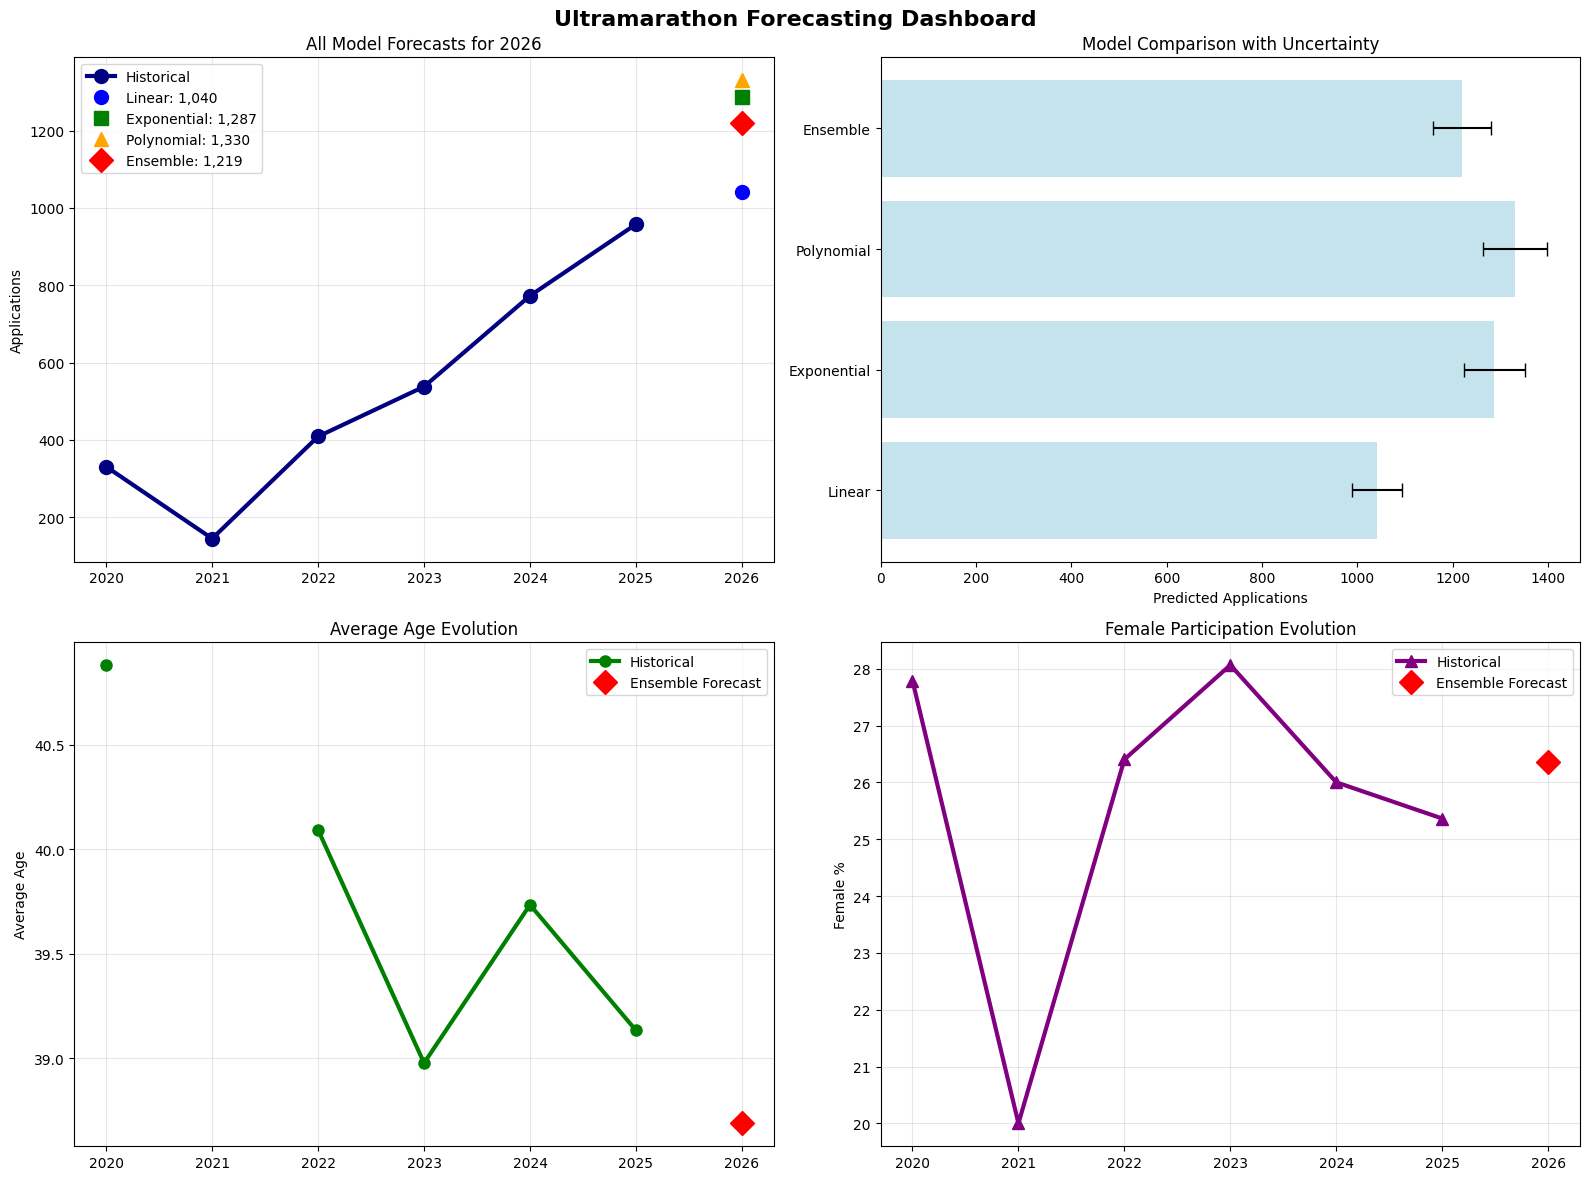

In [97]:
# Visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Ultramarathon Forecasting Dashboard', fontsize=16, fontweight='bold')

# Applications forecast - ALL MODELS
ax1 = axes[0, 0]
ax1.plot(years_list, applications_array, 'o-', linewidth=3, markersize=10, label='Historical', color='navy')
ax1.plot(2026, linear_pred, 'o', markersize=10, label=f'Linear: {linear_pred:,.0f}', color='blue')
ax1.plot(2026, exp_pred, 's', markersize=10, label=f'Exponential: {exp_pred:,.0f}', color='green')
ax1.plot(2026, poly_pred, '^', markersize=10, label=f'Polynomial: {poly_pred:,.0f}', color='orange')
ax1.plot(2026, ensemble_pred, 'D', markersize=12, label=f'Ensemble: {ensemble_pred:,.0f}', color='red')
ax1.set_title('All Model Forecasts for 2026')
ax1.set_ylabel('Applications')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(years_list + [2026])

# Model comparison with error bars
ax2 = axes[0, 1]
model_names = list(models_results.keys())
model_preds = [models_results[name]['prediction'] for name in model_names]
# Calculate error bars as percentage of prediction (simplified uncertainty)
error_bars = [pred * 0.05 for pred in model_preds]  # 5% uncertainty
ax2.barh(model_names, model_preds, xerr=error_bars, capsize=5, color='lightblue', alpha=0.7)
ax2.set_title('Model Comparison with Uncertainty')
ax2.set_xlabel('Predicted Applications')

# Age trend - ENSEMBLE ONLY
ax3 = axes[1, 0]
ax3.plot(years_list, summary_df['avg_age'], 'o-', linewidth=3, markersize=8, color='green', label='Historical')
ax3.plot(2026, demographic_forecasts['avg_age']['predicted'], 'D', markersize=12, color='red', label='Ensemble Forecast')
ax3.set_title('Average Age Evolution')
ax3.set_ylabel('Average Age')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(years_list + [2026])

# Gender trend - ENSEMBLE ONLY
ax4 = axes[1, 1]
ax4.plot(years_list, summary_df['female_percent'], '^-', linewidth=3, markersize=8, color='purple', label='Historical')
ax4.plot(2026, demographic_forecasts['female_percent']['predicted'], 'D', markersize=12, color='red', label='Ensemble Forecast')
ax4.set_title('Female Participation Evolution')
ax4.set_ylabel('Female %')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(years_list + [2026])

plt.tight_layout()
plt.show()

In [1]:
# Cell 2: Build Random Forest Model to Predict Return Probability
print('=== BUILDING RANDOM FOREST MODEL ===')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create training dataset from person_history
training_data = []
feature_names = ['age', 'gender_encoded', 'state_encoded', 'years_since_first', 
                'total_applications', 'avg_prev_apps', 'avg_prev_finishes', 
                'avg_volunteer', 'avg_trailwork', 'consistency_score', 'recent_activity']

# Encode categorical variables
le_gender = LabelEncoder()
le_state = LabelEncoder()

# Collect all unique values first for consistent encoding
all_genders = []
all_states = []
for person_id, data in person_history.items():
    all_genders.append(data['gender'])
    all_states.append(data['state'])

le_gender.fit(all_genders)
le_state.fit(all_states)

# Create training examples for each person-year combination where we can predict next year
for person_id, data in person_history.items():
    years_applied = sorted(data['years_applied'])
    
    # For each year this person applied, create features and target for next year
    for i, year in enumerate(years_applied[:-1]):  # Exclude last year since we can't predict after it
        next_year = year + 1
        returns_next_year = next_year in years_applied
        
        # Calculate features up to current year
        years_so_far = years_applied[:i+1]
        
        # Basic demographics
        age = data['latest_age'] - (max(years_applied) - year)  # Estimate age in that year
        gender_encoded = le_gender.transform([data['gender']])[0]
        state_encoded = le_state.transform([data['state']])[0]
        
        # Experience features
        years_since_first = year - min(years_applied)
        total_applications = len(years_so_far)
        
        # Performance metrics (average up to current year)
        patterns_so_far = i + 1
        avg_prev_apps = np.mean(data['application_pattern'][:patterns_so_far])
        avg_prev_finishes = np.mean(data['finish_pattern'][:patterns_so_far])
        avg_volunteer = np.mean(data['volunteer_pattern'][:patterns_so_far])
        avg_trailwork = np.mean(data['trailwork_pattern'][:patterns_so_far])
        
        # Consistency score (how regularly they apply)
        expected_years = year - min(years_applied) + 1
        consistency_score = len(years_so_far) / expected_years if expected_years > 0 else 1
        
        # Recent activity (applied in last 2 years before current year?)
        recent_years = [y for y in years_so_far if y >= year - 1]
        recent_activity = len(recent_years)
        
        features = [age, gender_encoded, state_encoded, years_since_first, total_applications,
                   avg_prev_apps, avg_prev_finishes, avg_volunteer, avg_trailwork,
                   consistency_score, recent_activity]
        
        training_data.append(features + [returns_next_year])

# Convert to arrays
training_array = np.array(training_data)
X = training_array[:, :-1].astype(float)
y = training_array[:, -1].astype(bool)

print(f'Training samples: {len(X):,}')
print(f'Return rate in training: {y.mean():.1%}')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

# Evaluate model
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f'\nModel Performance:')
print(f'Training accuracy: {train_score:.3f}')
print(f'Test accuracy: {test_score:.3f}')
print(f'Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f'\nTop Feature Importances:')
for _, row in feature_importance.head(8).iterrows():
    print(f'{row["feature"]}: {row["importance"]:.3f}')

# Detailed evaluation on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f'\nTest Set Evaluation:')
print(classification_report(y_test, y_pred))

# Check if we're getting reasonable return probabilities
print(f'\nPredicted return probabilities:')
print(f'Mean: {y_pred_proba.mean():.3f}')
print(f'Std: {y_pred_proba.std():.3f}')
print(f'Min: {y_pred_proba.min():.3f}')
print(f'Max: {y_pred_proba.max():.3f}')

# Store encoders and model for next cell
model_artifacts = {
    'model': rf_model,
    'le_gender': le_gender,
    'le_state': le_state,
    'feature_names': feature_names
}

=== BUILDING RANDOM FOREST MODEL ===


NameError: name 'person_history' is not defined